*Note: This file is provided in two formats: 
Python (simpleExample.py) and a Jupyter 
notebook (simpleExample.ipynb).  The 
Jupyter notebook opens in a web browser and 
includes plots in an interactive format.  To 
open the .ipynb file, run:*
    
    jupyter notebook simpleExample.ipynb

*To run the .py file in iPython at the command line, run:*

    ipython
    %run simpleExample.py
    plt.show()

simpleExample.ipynb
-------------------

- Bryan Daniels

- Last updated 2022/6/13

- Uses a simple exponential decay example to demonstrate usage of SirIsaac

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from SirIsaac import fittingProblem

Load example data
-----------------

In the example data file, we have five columns, each with 100 data points, listing:

* Initial condition *x_init*
* Input condition *tau*
* Measurement time *t*
* Measurement value *x*
* Measurement uncertainty (standard deviation)

In [2]:
data = np.loadtxt('simpleExample_data.csv',delimiter=',')

In [3]:
print(data)

[[ 1.12722743e+00  9.52191723e-01  5.45470151e-01  5.31344985e-01
   1.00000000e-01]
 [ 1.40339930e+00  9.34017762e-01  1.71865315e-01  1.22493271e+00
   1.00000000e-01]
 [ 1.14008665e+00  3.55914605e-01  8.52931809e-01  2.10974458e-01
   1.00000000e-01]
 [ 1.57730808e+00  2.17820948e-02  1.80223411e-01 -3.24462950e-02
   1.00000000e-01]
 [ 1.21683337e+00  5.30320309e-02  5.88700050e-01 -3.81103200e-02
   1.00000000e-01]
 [ 1.99983883e+00  4.58524908e-01  1.20774901e-01  1.58003284e+00
   1.00000000e-01]
 [ 1.44495342e+00  8.87106058e-01  5.54698750e-01  5.87526434e-01
   1.00000000e-01]
 [ 1.16351117e+00  9.20550105e-02  8.20261780e-02  5.18205744e-01
   1.00000000e-01]
 [ 1.33665808e+00  1.87080315e-02  9.92705175e-01 -2.19006338e-01
   1.00000000e-01]
 [ 1.11992003e+00  1.85032377e-01  2.52719261e-01  5.47132380e-01
   1.00000000e-01]
 [ 1.56278549e+00  5.98528655e-01  5.32960013e-01  7.41995589e-01
   1.00000000e-01]
 [ 1.30008094e+00  8.34177542e-01  8.92139097e-01  5.32527399e-01

We now put this in a format compatible with SirIsaac.  First we make a list of input values (in this case initial conditions):



In [4]:
indepParamsList = [ [ expt[0],expt[1] ] for expt in data ]

In [5]:
print(indepParamsList)

[[1.1272274339047885, 0.9521917233976885], [1.403399302209734, 0.9340177624532441], [1.140086651015479, 0.3559146053469723], [1.5773080794615506, 0.02178209477247628], [1.2168333686098407, 0.0530320309059672], [1.9998388284029764, 0.45852490838837445], [1.4449534179985184, 0.8871060581453715], [1.1635111684749644, 0.09205501049609743], [1.3366580761021054, 0.01870803151188616], [1.1199200343918003, 0.18503237716582788], [1.5627854949657647, 0.5985286545134162], [1.3000809425075959, 0.8341775417640426], [1.368757800139064, 0.5161941594493537], [1.4716207806643282, 0.2345928560158308], [1.5942752586734845, 0.05308289427916191], [1.0013599177918602, 0.261034134829341], [1.1469554602480456, 0.44840749838350136], [1.474729113715794, 0.5150329032371205], [1.5705656918953312, 0.23339594112507056], [1.5184361018947254, 0.9649168541918123], [1.869549633042161, 0.9463714274003613], [1.2734278475598397, 0.1968606149229407], [1.7489605356745521, 0.8012014063932036], [1.9377270860445428, 0.84713509

In [6]:
indepParamsList[:3]

[[1.1272274339047885, 0.9521917233976885],
 [1.403399302209734, 0.9340177624532441],
 [1.140086651015479, 0.3559146053469723]]

Next, we have a corresponding list of data taken at each of those input values, in the format below.  In this case, we only have one variable *x*.  (Note: In general, multiple timepoints could be also be measured at each input value; in all of our examples, we measure all variables at a single timepoint per input value.)

In [7]:
# [ {'var1': { time0: ( value, uncertainty ) },
#    'var2': { time0: ( value, uncertainty ) },
#     ... },
#   {'var1': { time1: ( value, uncertainty ) },
#    'var2': { time1: ( value, uncertainty ) },
#     ... },
#   ... ]

In [8]:
sirIsaacData = []
for expt in data:
    sirIsaacData.append( { 'x': { expt[2]: ( expt[3], expt[4] ) } } )

In [9]:
sirIsaacData[:3]

[{'x': {0.5454701510335127: (0.531344985497982, 0.1)}},
 {'x': {0.17186531503221092: (1.2249327126800098, 0.1)}},
 {'x': {0.8529318094853018: (0.21097445827304884, 0.1)}}]

Finally, SirIsaac will need to know what to call the input and output values.  In this case, the input corresponds to the initial value of *x*.  The way to indicate this to SirIsaac is by using the name 'x_init', where 'x' is the name of the corresponding variable.

Here we have two inputs and one output:

In [10]:
outputNames = ['x']
indepParamNames = ['x_init','tau']

Create SirIsaac FittingProblem
------------------------------

We'll attempt to fit a model in the "continuous time sigmoidal network" (CTSN) class.  To do this, we'll create an instance of a CTSNFittingProblem.  Here we set up its arguments and create it:

In [11]:
# complexityList lists which models in the model class may be tested.
# (Note that by default SirIsaac will still stop once 3 models have 
#  smaller estimated log-likelihood.)
complexityStepsize = 2 # increase complexity with steps of size 2
complexityMax = 25 # don't try models with complexity > 25
complexityList = range(0,complexityMax,complexityStepsize) 

# ensGen controls the generation of the initial ensemble of 
# parameter starting points.
# (We use a small number for totalSteps here so that the example
# runs faster; a more typical value for totalSteps is 1e3)
totalSteps = 20 #1e3 
keepSteps = 10
seeds = (1,1) # use a fixed random seed
ensTemperature = 100.
ensGen = fittingProblem.EnsembleGenerator( totalSteps, keepSteps,
    temperature=ensTemperature, seeds=seeds )

# Parameters that control when local fitting stops.
avegtol = 1e-2
maxiter = 100

# priorSigma controls the width of priors on all parameters
priorSigma = 3.

# If you have mpi4py installed, you can run on multiple processors
numprocs = 4 #10

# We'll only use a subset of our data to make the example run faster
N = 20

p = fittingProblem.CTSNFittingProblem( complexityList, 
    sirIsaacData[:N], indepParamsList=indepParamsList[:N], 
    outputNames=outputNames, indepParamNames=indepParamNames, 
    ensGen=ensGen, avegtol=avegtol, maxiter=maxiter,
    priorSigma=priorSigma, numprocs=numprocs, verbose=True )

Run parameter fitting
---------------------

The bulk of computation time is used to fit the parameters of each model to the data.  Uncomment the following lines to run the parameter fitting, which takes an hour or two using 4 processors.  Or skip ahead to load a version that has already been fit.

In [12]:
## Uncomment to run parameter fitting.
p.fitAll()
#
fittingProblem.save(p,'simpleExample_savedFittingProblem.pkl')

running build_ext
running build_src
build_src
building extension "CTSN_0_penguindeMacBook_Pro_local_530381_1676495861_47045" sources
f2py options: []
f2py: CTSN_0_penguindeMacBook_Pro_local_530381_1676495861_47045.pyf
Reading fortran codes...
	Reading file 'CTSN_0_penguindeMacBook_Pro_local_530381_1676495861_47045.pyf' (format:free)
Post-processing...
	Block: CTSN_0_penguindeMacBook_Pro_local_530381_1676495861_47045
			Block: res_function
			Block: ddaskr_jac
			Block: root_func
			Block: alg_deriv_func
			Block: alg_res_func
			Block: dres_dc_function
			Block: dres_dcdot_function
			Block: dres_dwself_1
			Block: dres_dlog_tau_1
			Block: dres_dw_1_0
			Block: sens_rhs
			Block: res_function_logdv
			Block: root_func_logdv
			Block: sens_rhs_logdv
			Block: integrate_stochastic_tidbit
Post-processing (stage 2)...
Building modules...
	Building module "CTSN_0_penguindeMacBook_Pro_local_530381_1676495861_47045"...
		Constructing wrapper function "res_function"...
		  residual = res_func

<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


customize UnixCCompiler using build_ext
CCompilerOpt.cc_test_flags[999] : testing flags (-march=native)
C compiler: gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/penguinaugustus/opt/anaconda3/include -arch x86_64 -I/Users/penguinaugustus/opt/anaconda3/include -arch x86_64

creating /var/folders/bg/39vt9f9n0q91qvvxfx8t52r40000gn/T/tmp43cf1ywp/Users
creating /var/folders/bg/39vt9f9n0q91qvvxfx8t52r40000gn/T/tmp43cf1ywp/Users/penguinaugustus
creating /var/folders/bg/39vt9f9n0q91qvvxfx8t52r40000gn/T/tmp43cf1ywp/Users/penguinaugustus/opt
creating /var/folders/bg/39vt9f9n0q91qvvxfx8t52r40000gn/T/tmp43cf1ywp/Users/penguinaugustus/opt/anaconda3
creating /var/folders/bg/39vt9f9n0q91qvvxfx8t52r40000gn/T/tmp43cf1ywp/Users/penguinaugustus/opt/anaconda3/lib
creating /var/folders/bg/39vt9f9n0q91qvvxfx8t52r40000gn/T/tmp43cf1ywp/Users/penguinaugustus/opt/anaconda3/lib/python3.8
creating /var/folders/bg/39vt9f9n0q91qvvxfx8t52r40000gn/

<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


CCompilerOpt.generate_dispatch_header[2245] : dispatch header dir build/src.macosx-10.9-x86_64-3.8/numpy/distutils/include does not exist, creating it
Detected changes on compiler optimizations, force rebuilding
building 'CTSN_0_penguindeMacBook_Pro_local_616839_4507495861_47045' extension
compiling C sources
C compiler: gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/penguinaugustus/opt/anaconda3/include -arch x86_64 -I/Users/penguinaugustus/opt/anaconda3/include -arch x86_64

creating build/temp.macosx-10.9-x86_64-3.8/Users
creating build/temp.macosx-10.9-x86_64-3.8/Users/penguinaugustus
creating build/temp.macosx-10.9-x86_64-3.8/Users/penguinaugustus/SloppyCell
creating build/temp.macosx-10.9-x86_64-3.8/Users/penguinaugustus/SloppyCell/SloppyCell
creating build/temp.macosx-10.9-x86_64-3.8/Users/penguinaugustus/SloppyCell/SloppyCell/ReactionNetworks
creating build/temp.macosx-10.9-x86_64-3.8/build
creating build/temp

<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


***STDOUT***
b''
***STDERR***
b''
SloppyCellFittingModel.fitToData: generating ensemble for these parameters: ['wself_1', 'theta_1', 'log_tau_1', 'w_1_0', 'w_1_2', 'w_2_1', 'w_2_0', 'X_2_init']
generateEnsemble_parallel: Generating parameter ensemble with 20 total members, using 4 processors.
SloppyCellFittingModel.fitToData: Cost = 104.55529221236701 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 103.74423054265564 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 103.45697407349847 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 103.38019643233056 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 103.5002781202935 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 104.7762894041013 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 104.58730405622158 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 104.06627287526437 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 103.85074820568322 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 102.85063808977046 ( 1 )
SloppyCellFittingModel.fitToData: Best-fit cost 

/Users/penguinaugustus/SloppyCell/SloppyCell/ReactionNetworks/Dynamics.py:711: RuntimeWarning: divide by zero encountered in true_divide
  ypIC[N_dyn_vars:] /= net.get_var_ic(opt_var)


fittingProblem.fitAll: L = -71.91118730091047
running build_ext
running build_src
build_src
building extension "CTSN_0_penguindeMacBook_Pro_local_879960_1047495861_47045" sources
f2py options: []
f2py: CTSN_0_penguindeMacBook_Pro_local_879960_1047495861_47045.pyf
Reading fortran codes...
	Reading file 'CTSN_0_penguindeMacBook_Pro_local_879960_1047495861_47045.pyf' (format:free)
Post-processing...
	Block: CTSN_0_penguindeMacBook_Pro_local_879960_1047495861_47045
			Block: res_function
			Block: ddaskr_jac
			Block: root_func
			Block: alg_deriv_func
			Block: alg_res_func
			Block: dres_dc_function
			Block: dres_dcdot_function
			Block: dres_dwself_1
			Block: dres_dtheta_1
			Block: dres_dlog_tau_1
			Block: dres_dw_1_0
			Block: dres_dw_1_2
			Block: dres_dwself_2
			Block: dres_dlog_tau_2
			Block: dres_dw_2_1
			Block: dres_dw_2_0
			Block: dres_dX_2_init
			Block: sens_rhs
			Block: res_function_logdv
			Block: root_func_logdv
			Block: sens_rhs_logdv
			Block: integrate_stochasti

<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


		Constructing wrapper function "integrate_stochastic_tidbit"...
		  time_ptr,dv,stop_time_ptr,trajectory = integrate_stochastic_tidbit(seed_ptr,reseed,time_ptr,dv,cv,rmsd_ptr,stop_time_ptr)
	Wrote C/API module "CTSN_0_penguindeMacBook_Pro_local_879960_1047495861_47045" to file "./CTSN_0_penguindeMacBook_Pro_local_879960_1047495861_47045module.c"
  adding 'build/src.macosx-10.9-x86_64-3.8/./fortranobject.c' to sources.
  adding 'build/src.macosx-10.9-x86_64-3.8/.' to include_dirs.
copying /Users/penguinaugustus/opt/anaconda3/lib/python3.8/site-packages/numpy/f2py/src/fortranobject.c -> build/src.macosx-10.9-x86_64-3.8/.


***STDOUT***
b''
***STDERR***
b''
SloppyCellFittingModel.fitToData: generating ensemble for these parameters: ['wself_1', 'theta_1', 'log_tau_1', 'w_1_0', 'w_1_2', 'wself_2', 'log_tau_2', 'w_2_1', 'w_2_0', 'X_2_init']
generateEnsemble_parallel: Generating parameter ensemble with 20 total members, using 4 processors.
SloppyCellFittingModel.fitToData: Cost = 104.31417857036543 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 106.64593448375115 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 105.72363552965213 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 103.22881002850504 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 102.88658163521569 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 105.23069512625649 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 105.25692059958092 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 102.45527025785351 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 104.91369594254866 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 102.85063808977046 ( 1 )
SloppyCellFittingModel

<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


		  sens_res = sens_rhs_logdv(time,sens_y_log,sens_yp_log,constants)
		Constructing wrapper function "integrate_stochastic_tidbit"...
		  time_ptr,dv,stop_time_ptr,trajectory = integrate_stochastic_tidbit(seed_ptr,reseed,time_ptr,dv,cv,rmsd_ptr,stop_time_ptr)
	Wrote C/API module "CTSN_0_penguindeMacBook_Pro_local_944942_2267495861_47045" to file "./CTSN_0_penguindeMacBook_Pro_local_944942_2267495861_47045module.c"
  adding 'build/src.macosx-10.9-x86_64-3.8/./fortranobject.c' to sources.
  adding 'build/src.macosx-10.9-x86_64-3.8/.' to include_dirs.
copying /Users/penguinaugustus/opt/anaconda3/lib/python3.8/site-packages/numpy/f2py/src/fortranobject.c -> build/src.macosx-10.9-x86_64-3.8/.


***STDOUT***
b''
***STDERR***
b''
SloppyCellFittingModel.fitToData: generating ensemble for these parameters: ['wself_1', 'theta_1', 'log_tau_1', 'w_1_0', 'w_1_2', 'w_1_3', 'wself_2', 'theta_2', 'log_tau_2', 'w_2_1', 'w_2_0', 'X_2_init', 'X_3_init']
generateEnsemble_parallel: Generating parameter ensemble with 20 total members, using 4 processors.
SloppyCellFittingModel.fitToData: Cost = 99.2738614185416 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 99.28376953003479 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 99.46286258211617 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 100.05769545088604 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 100.80623739660146 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 100.25077087116756 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 100.12476193337024 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 101.07368031201813 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 101.17018734220964 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 102.40914917619386 

<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


		Constructing wrapper function "dres_dX_2_init"...
		  pd = dres_dX_2_init(time,dynamicVars,yprime,constants)
		Constructing wrapper function "dres_dw_3_1"...
		  pd = dres_dw_3_1(time,dynamicVars,yprime,constants)
		Constructing wrapper function "dres_dw_3_0"...
		  pd = dres_dw_3_0(time,dynamicVars,yprime,constants)
		Constructing wrapper function "dres_dX_3_init"...
		  pd = dres_dX_3_init(time,dynamicVars,yprime,constants)
		Constructing wrapper function "sens_rhs"...
		  sens_res = sens_rhs(time,sens_y,sens_yp,constants)
		Constructing wrapper function "res_function_logdv"...
		  residual = res_function_logdv(time,log_dv,log_yp,constants)
		Constructing wrapper function "root_func_logdv"...
		  root_devs = root_func_logdv(t,log_dv,log_yp,constants)
		Constructing wrapper function "sens_rhs_logdv"...
		  sens_res = sens_rhs_logdv(time,sens_y_log,sens_yp_log,constants)
		Constructing wrapper function "integrate_stochastic_tidbit"...
		  time_ptr,dv,stop_time_ptr,trajectory = integr

***STDOUT***
b''
***STDERR***
b''
SloppyCellFittingModel.fitToData: generating ensemble for these parameters: ['wself_1', 'theta_1', 'log_tau_1', 'w_1_0', 'w_1_2', 'w_1_3', 'wself_2', 'theta_2', 'log_tau_2', 'w_2_1', 'w_2_0', 'X_2_init', 'w_3_1', 'w_3_0', 'X_3_init']
generateEnsemble_parallel: Generating parameter ensemble with 20 total members, using 4 processors.
SloppyCellFittingModel.fitToData: Cost = 99.1976300326942 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 99.18790410895107 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 100.46533653359107 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 99.08497396240492 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 99.62626888321242 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 97.48384856348135 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 96.35056626895594 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 98.2619479585348 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 98.38256487280604 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 97.2260

<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?


		Constructing wrapper function "res_function_logdv"...
		  residual = res_function_logdv(time,log_dv,log_yp,constants)
		Constructing wrapper function "root_func_logdv"...
		  root_devs = root_func_logdv(t,log_dv,log_yp,constants)
		Constructing wrapper function "sens_rhs_logdv"...
		  sens_res = sens_rhs_logdv(time,sens_y_log,sens_yp_log,constants)
		Constructing wrapper function "integrate_stochastic_tidbit"...
		  time_ptr,dv,stop_time_ptr,trajectory = integrate_stochastic_tidbit(seed_ptr,reseed,time_ptr,dv,cv,rmsd_ptr,stop_time_ptr)
	Wrote C/API module "CTSN_0_penguindeMacBook_Pro_local_326590_6519495861_47045" to file "./CTSN_0_penguindeMacBook_Pro_local_326590_6519495861_47045module.c"
  adding 'build/src.macosx-10.9-x86_64-3.8/./fortranobject.c' to sources.
  adding 'build/src.macosx-10.9-x86_64-3.8/.' to include_dirs.
copying /Users/penguinaugustus/opt/anaconda3/lib/python3.8/site-packages/numpy/f2py/src/fortranobject.c -> build/src.macosx-10.9-x86_64-3.8/.


***STDOUT***
b''
***STDERR***
b''
SloppyCellFittingModel.fitToData: generating ensemble for these parameters: ['wself_1', 'theta_1', 'log_tau_1', 'w_1_0', 'w_1_2', 'w_1_3', 'wself_2', 'theta_2', 'log_tau_2', 'w_2_1', 'w_2_0', 'w_2_3', 'X_2_init', 'w_3_1', 'w_3_0', 'w_3_2', 'X_3_init']
generateEnsemble_parallel: Generating parameter ensemble with 20 total members, using 4 processors.
SloppyCellFittingModel.fitToData: Cost = 107.3688598749003 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 99.63021657411382 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 99.6193462724665 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 100.32910111277714 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 100.26505235309989 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 101.03123328780205 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 97.66499576648349 ( 1 )
SloppyCellFittingModel.fitToData: Cost = 96.47771075730353 ( 0 )
SloppyCellFittingModel.fitToData: Cost = 99.03053219382451 ( 0 )
SloppyCellFittingModel.fitT

In [13]:
# Load saved version of fittingProblem that has already been fit.
#p = fittingProblem.load('simpleExample_savedFittingProblem.pkl')

Analyze the selected model
--------------------------

Here we plot predicted timecourses from the selected model for the first 10 in-sample initial conditions, using plotBestModelResults:

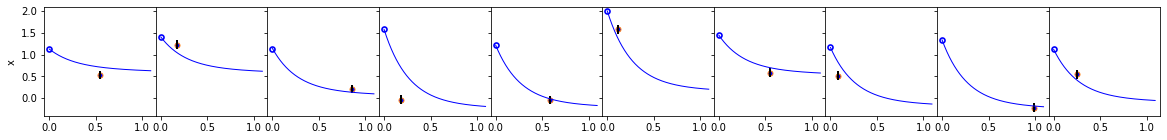

In [14]:
plt.figure(figsize=(20,2))
p.plotBestModelResults(plotInitialConditions=True,indices=range(10));

And now for out-of-sample data:

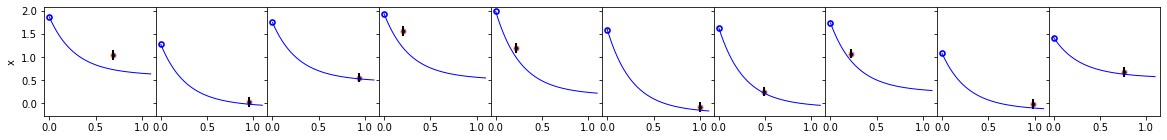

In [15]:
plt.figure(figsize=(20,2))
m = p.getBestModel()
m.plotResults(sirIsaacData[20:30],indepParamsList[20:30],
              plotInitialConditions=True,plotFittingData=True);

We can look at the selected model's parameters:

In [16]:
m = p.getBestModel()
print(m.getParameters())

[
('wself_1', -0.01905525855311797),
('theta_1', -0.10042336489771024),
('log_tau_1', -1.3429818941609932),
('w_1_0', 3.5028638262853438),
('w_1_2', -1.1983546770965334),
('wself_2', -1.377691298915458),
('log_tau_2', 0.3949860716779374),
('w_2_1', -1.0013279544798095),
('w_2_0', -0.5236628896994605),
('X_2_init', -0.2889053308674365),
]


The following will use SloppyCell to output a latex file with the ODEs describing the selected model:

In [17]:
m = p.getBestModel()
fittingProblem.IO.eqns_TeX_file(m.net,filename='simpleExample_selectedModel.tex')

More details
------------

We can examine the dynamics of the hidden nodes as well using plotResults.

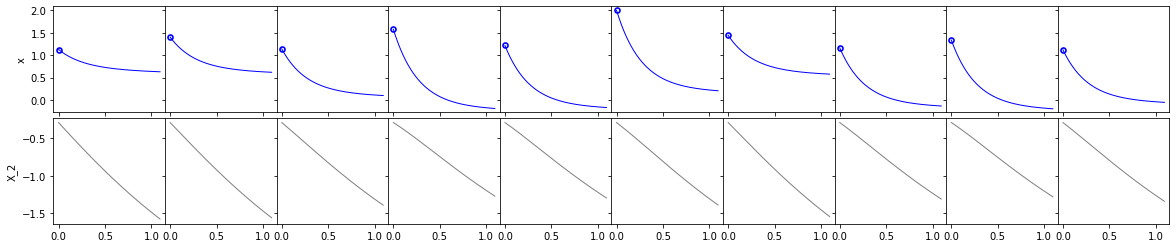

In [18]:
plt.figure(figsize=(20,4))
m = p.getBestModel()
m.plotResults(p.fittingData[:10],
              p.indepParamsList[:10],
              plotInitialConditions=True,
              plotHiddenNodes=True);

We have access to raw trajectories using evaluateVec.  Here we use this to plot a projection of trajectories in phase space for the first in-sample initial conditions:

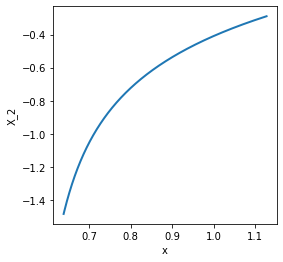

In [19]:
plt.figure(figsize=(4,4))
times = np.linspace(0,1,1000)
xdata = m.evaluateVec(times,'x',p.indepParamsList[0])
X2data = m.evaluateVec(times,'X_2',p.indepParamsList[0])
fittingProblem.Plotting.plot(xdata,X2data)
plt.xlabel('x')
plt.ylabel('X_2');

We can also look at other models that SirIsaac fit in searching for the best one.  In this case, 'Model 4' was selected because it has the largest estimated log-likelihood:

In [20]:
for name in p.fittingModelNames:
    if name in p.logLikelihoodDict.keys():
        print('{}: #species = {}, #params = {}, L = {}'.format(name,
              len(p.fittingModelDict[name].speciesNames),
              p.numParametersDict[name],
              p.logLikelihoodDict[name]))
print()
print('Selected model:',p.maxLogLikelihoodName())

Model 1: #species = 2, #params = 3, L = -73.12272406756854
Model 2: #species = 3, #params = 6, L = -71.85157277889509
Model 3: #species = 3, #params = 8, L = -71.91118730091047
Model 4: #species = 3, #params = 10, L = -70.64509888028904
Model 5: #species = 4, #params = 13, L = -74.15267529631116
Model 6: #species = 4, #params = 15, L = -73.5794170162226
Model 7: #species = 4, #params = 17, L = -73.69419297082464

Selected model: Model 4


We can also look at predictions of a model with more parameters:

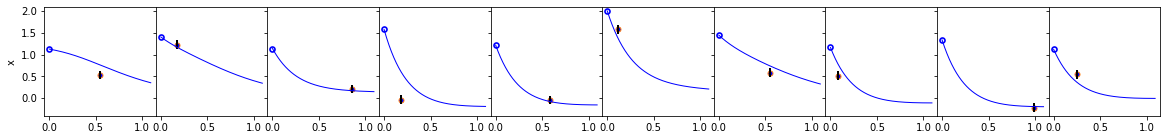

In [21]:
plt.figure(figsize=(20,2))
m2 = p.fittingModelDict['Model 7']
m2.plotResults(sirIsaacData[:10],indepParamsList[:10],
              plotInitialConditions=True,plotFittingData=True);

Also potentially useful is the Hessian at the best-fit parameters:

In [22]:
hess = p.HessianDict[p.maxLogLikelihoodName()]
u,singVals,vt = np.linalg.svd( hess )
np.sort(singVals)

array([1.11134041e-01, 1.11283180e-01, 1.12277342e-01, 1.16442583e-01,
       1.92911514e-01, 2.27930617e-01, 7.85855047e-01, 3.46607042e+02,
       4.13662200e+03, 3.94715198e+05])

Other details about what happened during parameter fitting are stored within each fittingModel:

In [23]:
m = p.getBestModel()
print("Acceptance ratio for initial parameter ensemble = {}".format(m.acceptanceRatio))
c = sum(np.array(m.currentResiduals(p.fittingData,p.indepParamsList,includePriors=False))**2)
print("Sum of squared residuals at best-fit (without priors) = {}".format(c))
print("Convergence flags for local fits: {}".format(m.convFlagList))
print("Number of cost evaluations for local fits: {}".format(m.numCostCallsList))
print("Number of gradient evaluations for local fits: {}".format(m.numGradCallsList))

Acceptance ratio for initial parameter ensemble = 1.0
Sum of squared residuals at best-fit (without priors) = 100.48242932539453
Convergence flags for local fits: [1, 0, 0, 1, 1, 0, 0, 0, 0, 1]
Number of cost evaluations for local fits: [188, 327, 304, 61, 76, 304, 304, 307, 304, 14]
Number of gradient evaluations for local fits: [58, 101, 101, 16, 21, 101, 101, 101, 101, 1]


Finally, since in this case we know the function used to create the data, we can compare:

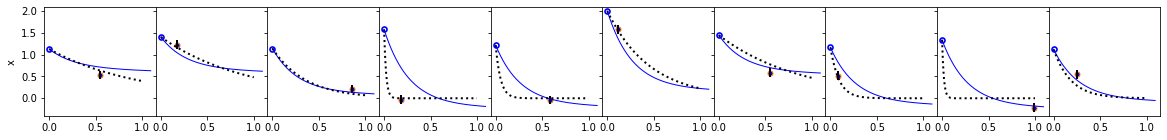

In [24]:
plt.figure(figsize=(20,2))
indicesToPlot = range(10)
axArray = p.plotBestModelResults(plotInitialConditions=True,indices=indicesToPlot)

# compare to model that generated the data (see simpleExample_makeData.py)
f = lambda x0,tau,t: x0 * np.exp(-times/tau)

for i,indepParams in enumerate(np.array(indepParamsList)[indicesToPlot]):
    times = np.linspace(0,1,100)
    x0,tau = indepParams
    fittingProblem.Plotting.sca(axArray[0][i])
    fittingProblem.Plotting.plot(times,f(x0,tau,times),'k:')